# <font color=blue>**TAREA 1** - Gradient descent en tensorflow

La tarea práctica consiste en usar el mismo dataset del proyecto del curso pasado y e implementar gradient descent aplicado a regresión con este (usando la variable con mayor correlación elegida en el proyecto en anterior(solo una de las 2 del proyecto)), hacer el entrenamiento con gradient descent pero usando tensorflow y usar tensorboard para monitorear que el error disminuya conforme avanzan las iteraciones "en vivo"(en lugar de hacerlo con matplotlib hasta el final como lo hicimos antes).

Para la parte de Tensorboard, este nos permite visualizar mucha información relevante, pero nos centraremos en 2 cosas : La curva de aprendizaje(disminución de error MSE en el tiempo)(en la la pestaña "scalars") El grafo que representa a nuestro modelo (en la pestaña "graphs")

Requisitos:

- Utilizar solo operaciones vectorizadas.
- Usar mini-batch gradient descent (tamaño de mini-batch debe ser un hyper-parametro con el cual se debe experimentar.)

Utilizar tensorboard(https://youtu.be/FEu1R3t_-4I):
- Agregar el grafo del modelo.
- Usar operaciones con nombre y usar name_spaces para mejorar el orden.
- Aplicar reutilización de código: por ejemplo usar programación orientada a objetos para crear el modelo y/o definir el entrenamiento dentro de funciones de python.
- Utilizar las funciones reutilizables de entrenamiento para ejecutar al menos 10 experimentos (variable numero de iteraciones, diferente learning rate y diferente tamaño de mini-batch)
- definir un string de configuración para cada experimento.
- crear un directorio para cada experimento basado en el string de configuración.

- Agregar un summary.scalar para monitorear el MSE.
- Utilizar un enfoque investigación científica: antes del experimento formular una hipótesis del comportamiento experado, ejecutar el experimento y utilizar los resultados de tensorboard para conculir.
- basado en los resultados experimentales obtenidos con tensorboard crear una conclusión general y elegir el mejor experimento.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import datetime, os

print(tf.__version__)

2.3.0


In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## <font color=blue>**Hipotesis**
Debido a que se espera crear un modelo que permita tener una mejor predicción de las variables, se determinara que parametros se acoplan mejor y producen un mejor resultado, buscando obtener los valoes que produzcan el mejor error.


In [3]:
PreciosCasas = np.load('proyecto_training_data.npy')

#TRAINING Y TESTING DATA
split_factor = 0.8
split = int(split_factor * PreciosCasas.shape[0])
DatosEntrenamiento = PreciosCasas[0:split+1]
DatosValidacionPrueba = PreciosCasas[split+1:]

DatosEntrenamiento_dataframe = pd.DataFrame(DatosEntrenamiento,columns=['SalesPrice','OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
DatosEntrenamiento_dataframe

,SalesPrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0
...,...,...,...,...,...,...
1164,194000.0,5.0,1432.0,5.0,1978.0,NaN
1165,233170.0,7.0,1502.0,7.0,2009.0,79.0
1166,245350.0,8.0,1694.0,7.0,2008.0,64.0
1167,173000.0,6.0,959.0,7.0,2000.0,58.0


TENSORBOARD

In [4]:
%load_ext tensorboard

In [5]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

In [6]:
#TENSORFLOW 
class ModeloLineal:
  def __init__(self):
    tf.reset_default_graph()
    self.mb = tf.get_variable("Pendiente_Intercepto",dtype=tf.float64,shape=[2,1],initializer=tf.zeros_initializer())
    self.error = tf.get_variable("Error",dtype=tf.float64,shape=[1],initializer=tf.zeros_initializer())
    
  def __call__(self,x):
    x = tf.concat([x,tf.ones_like(x,name="X_Vector_1")], axis=1,name="X_Addicion_1")  
    return tf.matmul(x,self.mb,name="Prediccion")

  def actualizar(self,x,y,learning_rate):
    prediccion = self(x)
    error = 1/2 * tf.math.reduce_mean(tf.math.square(y - prediccion,name="Error_Cuadrado"),axis=0,name="Error_Media") 
    gradiente = tf.gradients(error,self.mb, name="Gradiente")  
    actualizacion_error = tf.assign(self.error, error)
    actualizacion_parametros = tf.assign(self.mb,self.mb - tf.multiply(gradiente,learning_rate)[0],name="Actualizacion_Parametros")

    return actualizacion_parametros,actualizacion_error

In [7]:
#X = np.array([65.00,80.00,68.00]).reshape([-1,1])
#Y = np.array([208.5,181.5,223.5]).reshape([-1,1])
X = DatosEntrenamiento[:,1].reshape([-1,1])
Y = DatosEntrenamiento[:,0].reshape([-1,1])

#Hyper-Parametros
lr = 0.0001
bs = 500
ep = 500

In [8]:
def ModeloRegresionLineal(X,Y,learning_rate,batch_size,epochs):  
    #plt.scatter(X,Y)

    modelo = ModeloLineal()
    tamaño_muestra = X.shape[0]

    total_iteraciones =  int(tamaño_muestra/batch_size)

    #Definicion Tensores
    tensor_x = tf.placeholder(tf.float64,[None,1],"tensor_x")
    tensor_y = tf.placeholder(tf.float64,[None,1],"tensor_y")

    #Definicion Modelo
    prediccion = modelo(tensor_x)
    actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,learning_rate)

    with tf.train.MonitoredSession() as session:
        #Tensorboard Grafo
        tf.reset_default_graph()   
        log_dir = "logs/Entrenamiento/"+"BS-"+str(batch_size)+"_"+"LR-"+str(learning_rate)+"_"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        Grafo = tf.summary.FileWriter(log_dir, session.graph)


        for epoch in range(epochs):    
            for i in range(total_iteraciones):          
                muestra_inicio = i*batch_size
                muestra_fin = muestra_inicio + batch_size

                x_mb =  np.array(X[muestra_inicio:muestra_fin])
                y_mb = np.array(Y[muestra_inicio:muestra_fin])
                feed_dict = {tensor_x:x_mb, tensor_y:y_mb}
                _,mb,e = session.run([actualizacion_parametros,modelo.mb,modelo.error],feed_dict=feed_dict)            
                #print("Epoch {} iteracion {} mb={} e={}".format(epoch,i,mb,e))

                #Tensorboard Escalar
                summary = tf.Summary(value=[tf.Summary.Value(tag="Error", simple_value=e[0])])
                Grafo.add_summary(summary, epoch)

            feed_dict = {tensor_x:X, tensor_y:Y}
            #predicciones = session.run(prediccion,feed_dict=feed_dict)
            #plt.plot(X,predicciones,label=str(epoch))


        PendienteInter_final = session.run([modelo.mb],feed_dict=feed_dict)
        #plt.title("Parámetros finales: mb={}".format(PendienteInter_final))
        Grafo.close()

    #plt.legend()
    #plt.show()
    print("Analisis Finalizado")

**LR = 0.00001 EP= 500 DS=Variable (10, 100,500)**

In [10]:
ModeloRegresionLineal(X,Y,0.00001,10,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


In [11]:
ModeloRegresionLineal(X,Y,0.00001,100,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


In [9]:
ModeloRegresionLineal(X,Y,0.00001,500,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


**LR = 0.0001 EP= 500 DS=Variable (10, 100,500)**

In [12]:
ModeloRegresionLineal(X,Y,0.0001,10,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


In [13]:
ModeloRegresionLineal(X,Y,0.0001,100,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


In [14]:
ModeloRegresionLineal(X,Y,0.0001,500,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


**LR = 0.001 EP= 500 DS=Variable (10, 100,500)**

In [15]:
ModeloRegresionLineal(X,Y,0.001,10,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


In [16]:
ModeloRegresionLineal(X,Y,0.001,100,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


In [17]:
ModeloRegresionLineal(X,Y,0.001,500,500)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Analisis Finalizado


**TENSORBOARD**

In [18]:
%tensorboard --logdir logs/Entrenamiento

Reusing TensorBoard on port 6006 (pid 13772), started 8:07:52 ago. (Use '!kill 13772' to kill it.)

## <font color=blue>**Conclusión**
    
- Entre mayor es el tamaño del batch size peor es la estimacion del modelo, y el error es muy alto cuando su learning rate es bajo (0.00001)
- Cuando el tamaño del learning rate disminuye y el tamaño de batch es pequeño la estimacion del modelo es incorrecta, y el error es alto
- El mejor modelo seria el siguiente -> ModeloRegresionLineal(X,Y,0.0001,500,500) ya que nos produce un error bajo y sin mayor ruido

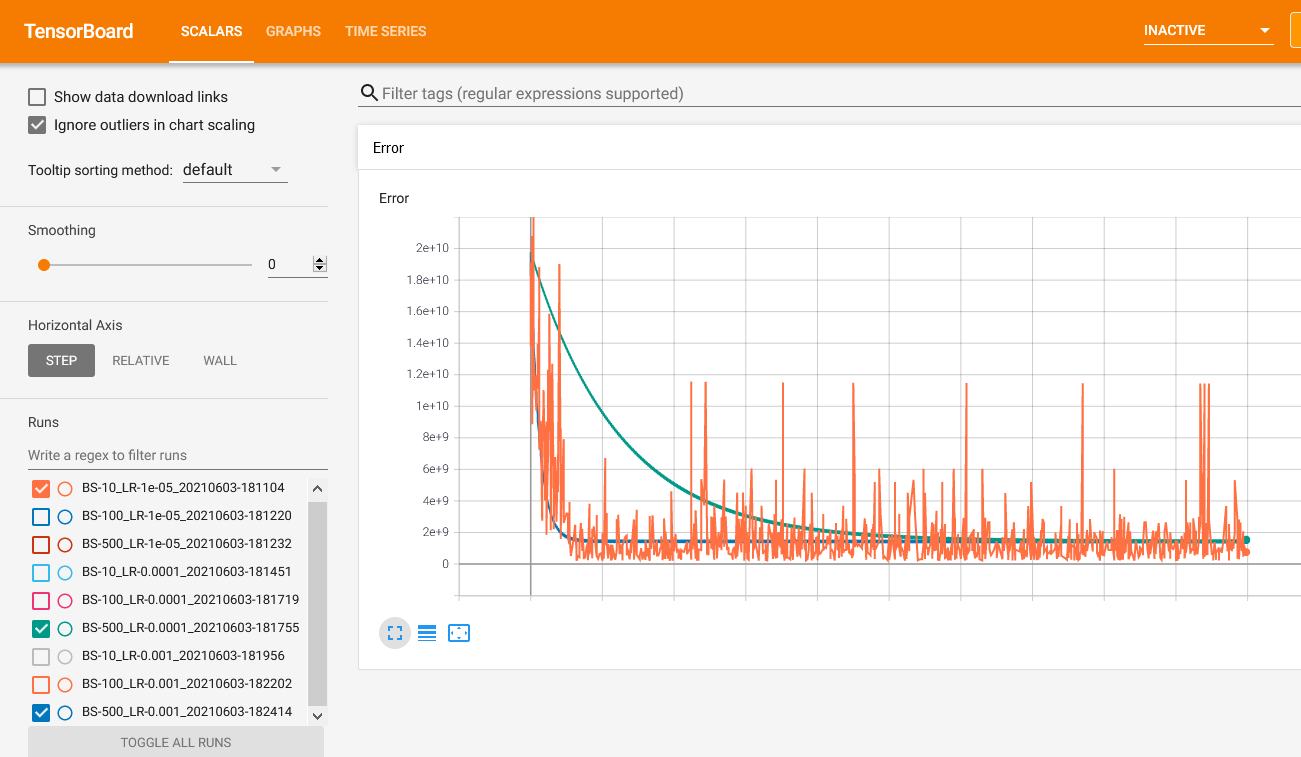

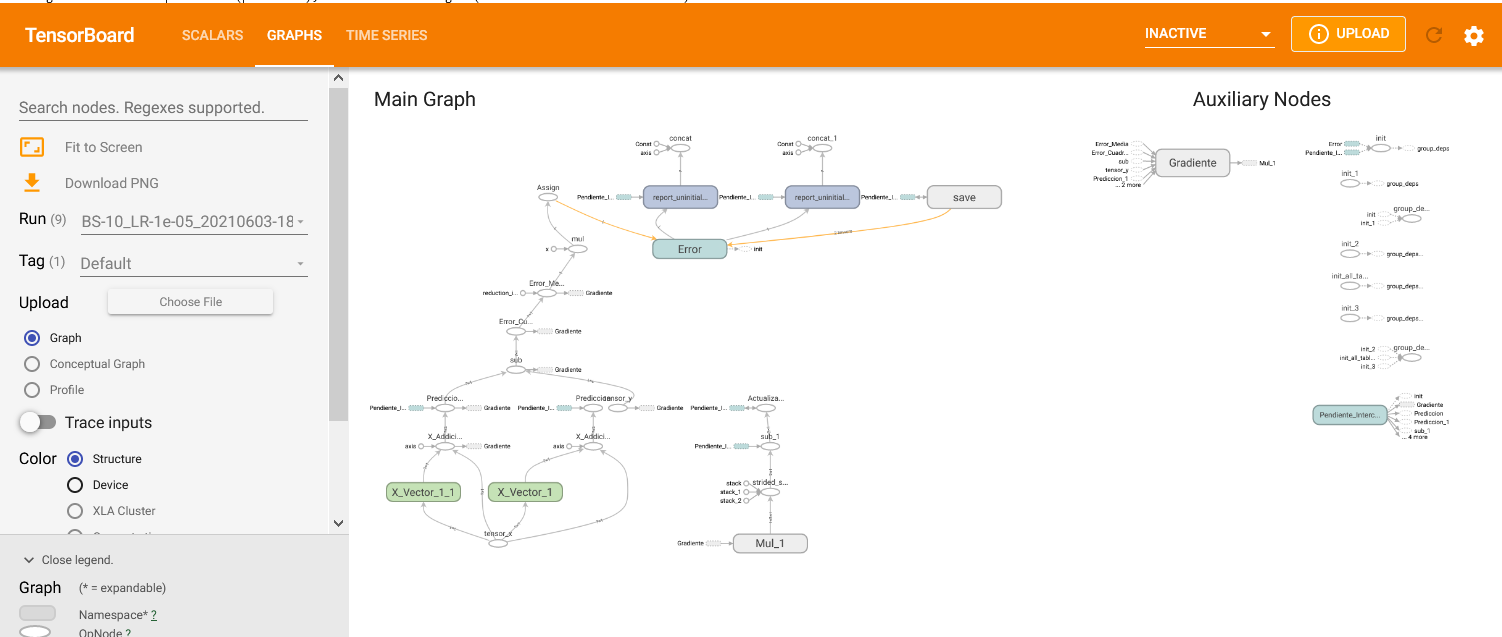